<a href="https://colab.research.google.com/github/mofuoku417/Univariate_Crude_Palm_Oil_Price_Prediction/blob/main/Univariate_Palm_Oil_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Load the Required Libraries

In [92]:
import math 
import numpy as np # Python's fundamental package for scientific computing
import pandas as pd # For data analysis and manipulation
from datetime import date, timedelta # Date Operations
import matplotlib.pyplot as plt # To aid in visualizing
import matplotlib.dates as mdates # Date formatting
from sklearn.metrics import mean_absolute_error, mean_squared_error # To assess model performance error computation
from sklearn.preprocessing import MinMaxScaler # to standardize the crude palm oil price data 
from tensorflow.keras.models import Sequential # Deep learning library, that is used in neural networks
from tensorflow.keras.layers import LSTM, Dense # Deep learning classes for densely linked recurrent and regular layers
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Establishing a timetable for data extraction
today = date.today()
end_date = today.strftime("%Y-%m")
start_date = '1993-03'

# Getting S&P500 quotes
stockname = 'cpo_pri'

path = '/content/df_cl.csv'
df = read_csv(path, parse_dates=True)

# Examining the dataset's structure
print(df.shape)
df.head(5)

(361, 2)


,date,cpo_pri
0,1993-03,408
1,1993-04,392
2,1993-05,371
3,1993-06,356
4,1993-07,362


In [93]:
df['date'] = pd.to_datetime(df['date'].apply(lambda x: x.split()[0])) # Selecting only date
df.set_index('date',drop=True,inplace=True) # Setting date column as index
df.head()

,cpo_pri
date,
1993-03-01,408
1993-04-01,392
1993-05-01,371
1993-06-01,356
1993-07-01,362


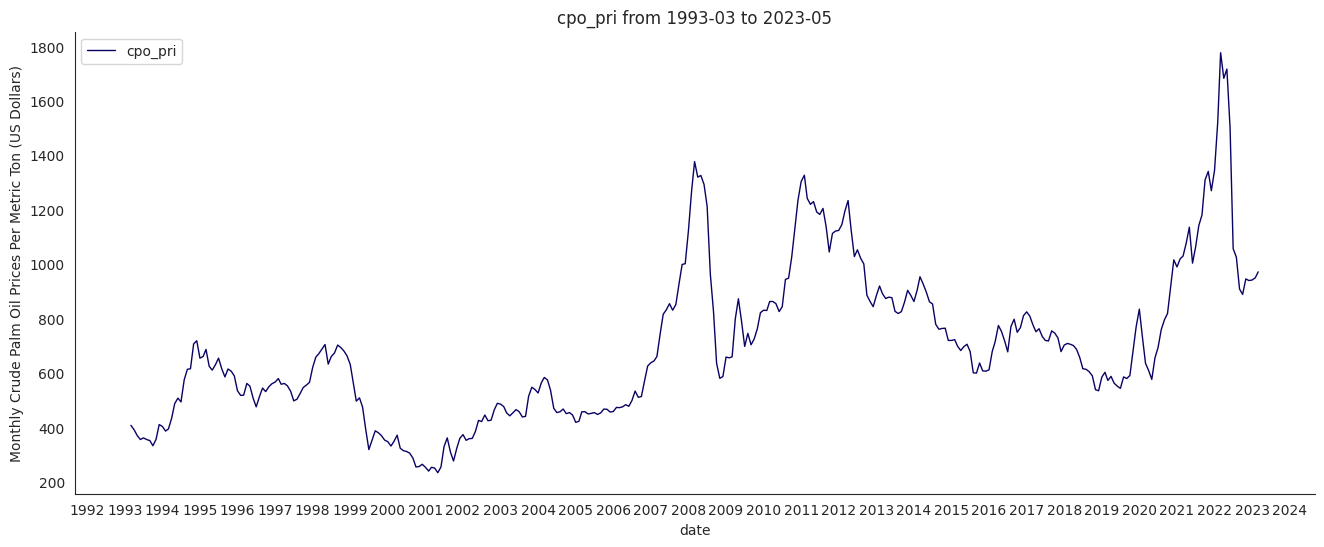

In [94]:
# Constructing a Lineplot
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['cpo_pri'], label=stockname, linewidth=1.0)
plt.ylabel('Monthly Crude Palm Oil Prices Per Metric Ton (US Dollars)')
plt.show()

In [95]:
# Target Selection 
train_df = df.filter(['cpo_pri'])
data_unsc = train_df.values # data_unscaled data

# Compute the number of rows required to train the model on 80% of the data. 
train_data_len = math.ceil(len(data_unsc) * 0.7)

# Scale each characteristic to a value between 0 and 1 to transform it.
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unsc)

In [96]:
# Set the sequence len - the period for making a single forecast.
sequence_len = 60

# Index of Prediction
index_cpo_pri = train_df.columns.get_loc("cpo_pri")
print(index_cpo_pri)
# Divide the training data into train and train data sets.
# In the first stage, we determine the number of rows required to train the model on 80% of the data. 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Generate training and test data.
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_len:, :]

# The LSTM model requires data in the following formats: [samples, time steps, features].
def partition_dataset(sequence_len, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_len, data_len):
        x.append(train_df[i-sequence_len:i,:]) 
        y.append(train_df[i, index_cpo_pri]) 
    
    # Convert the x and y variables to numpy arrays.
    x = np.array(x)
    y = np.array(y)
    return x, y

# Create training and testing data.
x_train, y_train = partition_dataset(sequence_len, train_data)
x_test, y_test = partition_dataset(sequence_len, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Verify that the prediction value and the input value match
print(x_test[1][sequence_len-1][index_cpo_pri])
print(y_test[0])

0
(229, 60, 1) (229,)
(72, 60, 1) (72,)
0.3357096565132858
0.3357096565132858


In [97]:
# Set up the neural network model
LSTM_model = Sequential()

neurons = sequence_len

LSTM_model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
LSTM_model.add(LSTM(neurons, return_sequences=False))
LSTM_model.add(Dense(25, activation='relu'))
LSTM_model.add(Dense(1))

# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

In [99]:
# Training the model
LSTM_model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
15/15 [==============================] - 1s 53ms/step - loss: 0.0015
Epoch 2/25
15/15 [==============================] - 1s 54ms/step - loss: 0.0018
Epoch 3/25
15/15 [==============================] - 1s 52ms/step - loss: 0.0018
Epoch 4/25
15/15 [==============================] - 1s 51ms/step - loss: 0.0017
Epoch 5/25
15/15 [==============================] - 1s 54ms/step - loss: 0.0017
Epoch 6/25
15/15 [==============================] - 1s 56ms/step - loss: 0.0021
Epoch 7/25
15/15 [==============================] - 1s 55ms/step - loss: 0.0020
Epoch 8/25
15/15 [==============================] - 1s 52ms/step - loss: 0.0017
Epoch 9/25
15/15 [==============================] - 1s 51ms/step - loss: 0.0014
Epoch 10/25
15/15 [==============================] - 1s 53ms/step - loss: 0.0015
Epoch 11/25
15/15 [==============================] - 1s 51ms/step - loss: 0.0016
Epoch 12/25
15/15 [==============================] - 1s 53ms/step - loss: 0.0013
Epoch 13/25
15/15 [==================

In [100]:
# Obtain the predicted values
LSTM_pred_scaled = LSTM_model.predict(x_test)
LSTM_pred = mmscaler.inverse_transform(LSTM_pred_scaled)
y_test_unsc = mmscaler.inverse_transform(y_test.reshape(-1, 1))

3/3 [==============================] - 1s 17ms/step


In [101]:
# Mean Absolute Error (MAE)
LSTM_MAE = mean_absolute_error(y_test_unsc, LSTM_pred)
print(f'Median Absolute Error (MAE): {np.round(LSTM_MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
LSTM_MAPE = np.mean((np.abs(np.subtract(y_test_unsc, LSTM_pred)/ y_test_unsc))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(LSTM_MAPE, 2)} %')

# Root Mean Squared Error (RMSE)
LSTM_RMSE = mean_squared_error(y_test_unsc, LSTM_pred) ** 0.5
print(f'Root Mean Squared Error (RMSE): {np.round(LSTM_RMSE, 2)} %')

# Mean Squared Error (MSE)
LSTM_MSE = mean_squared_error(y_test_unsc, LSTM_pred)
print('MSE value of the LSTM Model:', LSTM_MSE )

# r2_score
LSTM_r2 = r2_score(y_test_unsc, LSTM_pred)
print(f'R^2 Score: {np.round(LSTM_r2, 2)} %')

Median Absolute Error (MAE): 74.09
Mean Absolute Percentage Error (MAPE): 8.57 %
Root Mean Squared Error (RMSE): 99.65 %
MSE value of the LSTM Model: 9931.066323464322
R^2 Score: 0.89 %


In [102]:
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'x_train'})
train

,x_train
date,
1993-03-01,408
1993-04-01,392
1993-05-01,371
1993-06-01,356
1993-07-01,362
...,...
2016-12-01,811
2017-01-01,825
2017-02-01,809


<Axes: title={'center': 'LSTM Predictions vs Actual'}, xlabel='date', ylabel='cpo_pri'>

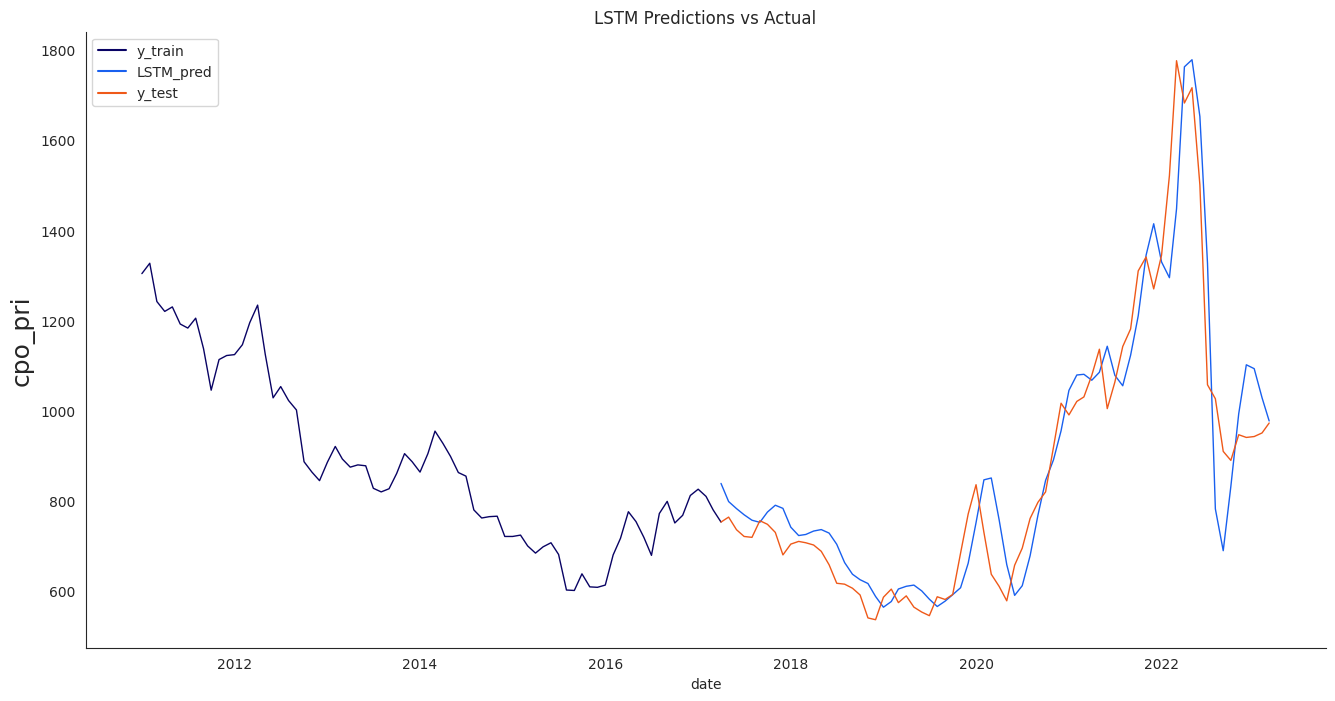

In [115]:
# The date from which on the date is displayed
display_start_date = "2010-12" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df[:train_data_len + 1]).rename(columns={'cpo_pri': 'y_train'})
valid = pd.DataFrame(train_df[train_data_len:]).rename(columns={'cpo_pri': 'y_test'})
valid.insert(1, "LSTM_pred", LSTM_pred, True)
valid.insert(1, "residuals", valid["LSTM_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
plt.title("LSTM Predictions vs Actual")
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_train', 'LSTM_pred', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)